# HMModel trainig

In this notebook we will train Hidden Markov Model for ECG signal annotation to find P-wave, QRS complex and T-wave using the [QT Database](https://www.physionet.org/physiobank/database/qtdb/) with labeled ECGs.

# Table of contents

* [Setting up](#Setting-up)
* [Helper functions](#Helper-functions)
* [Dataset initialization](#Dataset-initialization)
* [Preprocessing](#Preprocessing)
* [Training](#Training)
* [Prediction](#Prediction)

# Setting up

In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds
from cardio import EcgBatch
from cardio.dataset import B, V, F
from cardio.models.hmm import HMModel

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Helper functions

Here are helper functions to generate data for learning, to get values from pipeline, and to perform calculation of initial parameters of the HMM.

In [2]:
def prepare_batch(batch, model):
    X = np.concatenate([hmm_features[0,:,:].T for hmm_features in batch.hmm_features])
    lengths = [hmm_features.shape[2] for hmm_features in batch.hmm_features]
    return {"X": X, "lengths": lengths}

def get_annsamples(batch):
    return [ann["annsamp"] for ann in batch.annotation]

def get_anntypes(batch):
    return [ann["anntype"] for ann in batch.annotation]

def get_batch(batch):
    return [batch]

def expand_annotation(annsamp, anntype, length):
    begin = -1
    end = -1
    s = 'none'
    states = {'N':0, 'st':1,'t':2, 'iso':3, 'p':4, 'pq': 5}
    annot = -1 * np.ones(length)

    for j in range(len(annsamp)):
        if anntype[j] == '(':
            begin=annsamp[j]
            if (end > 0) & (s != 'none'):
                if s == 'N':
                    annot[end:begin] = states['st']
                elif s == 't':
                    annot[end:begin] = states['iso']
                elif s == 'p':
                    annot[end:begin] = states['pq']
        elif anntype[j] == ')':
            end = annsamp[j]
            if (begin > 0) & (s != 'none'):
                annot[begin:end] = states[s] 
        else: 
            s = anntype[j]
    
    return annot

def prepare_means_covars(hmm_features, clustering, states=[3, 5, 11, 14, 17, 19], num_states=19, num_features=3):
    """This function is specific to the task and the model configuration, thus contains hardcode.
    """
    means = np.zeros((num_states, num_features))
    covariances = np.zeros((num_states, num_features, num_features))
    
    # Prepearing means and variances
    last_state = 0
    unique_clusters = len(np.unique(clustering)) - 1 # Excuding value -1, which represents undefined state
    for state, cluster in zip(states, np.arange(unique_clusters)):
        value = hmm_features[clustering == cluster, :]
        means[last_state:state, :] = np.mean(value, axis=0)
        covariances[last_state:state, :, :] = value.T.dot(value) / np.sum(clustering == cluster)
        last_state = state
        
    return means, covariances

def prepare_transmat_startprob():
    """ This function is specific to the task and the model configuration, thus contains hardcode.
    """
    # Transition matrix - each row should add up tp 1
    transition_matrix = np.diag(19 * [14/15.0]) + np.diagflat(18 * [1/15.0], 1) + np.diagflat([1/15.0], -18)
    
    # We suppose that absence of P-peaks is possible
    transition_matrix[13,14]=0.9*1/15.0
    transition_matrix[13,17]=0.1*1/15.0

    # Initial distribution - should add up to 1
    start_probabilities = np.array(19 * [1/np.float(19)])
    
    return transition_matrix, start_probabilities                                      

# Dataset initialization

First, we need to specify paths to ECG signals:

In [3]:
SIGNALS_PATH = "path_to_QT_database"
SIGNALS_MASK = os.path.join(SIGNALS_PATH, "*.hea")

Next step is to create dataset and perform train/test split:

In [4]:
index = ds.FilesIndex(path=SIGNALS_MASK, no_ext=True, sort=True)
dtst = ds.Dataset(index, batch_class=EcgBatch)
dtst.cv_split(0.9)

# Preprocessing

We need to calculate initial parameters for the model to ease the learning process.
To do it, we will define template pipeline that loads data and accumulates the data we need for initial parameters in pipeline variables:

In [5]:
template_ppl_inits = (
    ds.Pipeline()
      .init_variable("annsamps", init_on_each_run=list)
      .init_variable("anntypes", init_on_each_run=list)
      .init_variable("hmm_features", init_on_each_run=list)
      .load(fmt='wfdb', components=["signal", "annotation", "meta"], ann_ext='pu1')
      .cwt(src="signal", dst="hmm_features", scales=[4,8,16], wavelet="mexh")
      .standardize(axis=-1, src="hmm_features", dst="hmm_features")
      .update_variable("annsamps", ds.F(get_annsamples), mode='e')
      .update_variable("anntypes", ds.F(get_anntypes), mode='e')
      .update_variable("hmm_features", ds.B("hmm_features"), mode='e')
      .run(batch_size=20, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

Now we link the dataset to the template pipeline:

In [6]:
ppl_inits = (dtst >> template_ppl_inits).run()

Next, we get values from pipeline variables and perform calculation of the models' initial parameters: means, covariances, transition matrix and initial probabilities.

In [7]:
lengths = [hmm_features.shape[2] for hmm_features in ppl_inits.get_variable("hmm_features")]
hmm_features = np.concatenate([hmm_features[0,:,:].T for hmm_features in ppl_inits.get_variable("hmm_features")])
anntype = ppl_inits.get_variable("anntypes")
annsamp = ppl_inits.get_variable("annsamps")

After this, we expand the annotation with helper function so that each observation has it's own label: 0 for QRS complex, 1 for ST segment, 2 for T-wave, 3 for ISO segment, 4 for P-wave, 5 for PQ segment and -1 for all other observations.

In [8]:
expanded = np.concatenate([expand_annotation(samp, types, length) for samp, types, length in zip(annsamp, anntype, lengths)])

Now using unravelled annotation calculate means and covariances for the states of the model:

In [9]:
means, covariances = prepare_means_covars(hmm_features, expanded, states = [3, 5, 11, 14, 17, 19], num_features = 3)

And, finally, define matrix of transitions between states and probabilities of the states:

In [10]:
transition_matrix, start_probabilities = prepare_transmat_startprob()

# Training

In config we first specify that we want model to be build from scratch rather than loaded. Next, pass the desired estimator and initial parameters that we calculated in previous section.

In [11]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=19, n_iter=25, covariance_type="full", random_state=42,
                                 init_params='', verbose=False),
    'init_params': {'means_': means, 'covars_': covariances, 'transmat_': transition_matrix,
                    'startprob_': start_probabilities}
                }

Training pipeline consists of the following actions:
* Model initialization (building)
* Data loading
* Preprocessing (e.g. wavelet transformation)
* Train step on current batch data

Let's create template pipeline:

In [12]:
ppl_train_template = (
    ds.Pipeline()
      .init_model("dynamic", HMModel, "HMM", config=config_train)
      .load(fmt='wfdb', components=["signal", "annotation", "meta"], ann_ext='pu1')
      .cwt(src="signal", dst="hmm_features", scales=[4,8,16], wavelet="mexh")
      .standardize(axis=-1, src="hmm_features", dst="hmm_features")
      .train_model("HMM", make_data=prepare_batch)
      .run(batch_size=20, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

Now we link this template to the dataset and run:

In [13]:
ppl_train = (dtst >> ppl_train_template).run()

From resulting pipeline we can save the trained model to file.

In [14]:
ppl_train.save_model("HMM", path="hmmodel.dill")

# Prediction

In this config we tell that we want to load existing model from specified path:

In [15]:
config_predict = {
    'build': False,
    'load': {'path': "hmmodel.dill"}
                 }

Prediction pipeline is somewhat more complex and composed of:
* Model initialization (loading)
* Initialization of pipeline variable
* Data loading
* Preprocesing
* Calculation of ECG parameters, such as HR
* Update of the variable

Template for this pipeline looks like this:

In [16]:
template_ppl_predict = (
    ds.Pipeline()
      .init_model("static", HMModel, "HMM", config=config_predict)
      .init_variable("batch", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "annotation", "meta"], ann_ext="pu1")
      .cwt(src="signal", dst="hmm_features", scales=[4,8,16], wavelet="mexh")
      .standardize(axis=-1, src="hmm_features", dst="hmm_features")
      .predict_model("HMM", make_data=prepare_batch, save_to=ds.B("hmm_annotation"), mode='w')
      .calc_ecg_parameters(src="hmm_annotation")
      .update_variable("batch", ds.F(get_batch), mode='e')
      .run(batch_size=20, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

Let's link pipieline to dataset and run:

In [17]:
ppl_predict = (dtst >> template_ppl_predict).run()

Now we can access values from pipeline variable. In this pipeline we have accumulated all the batches in this variable - let's take a look at some of them. First, select one the batches from pipeline variable:

In [18]:
batch = ppl_predict.get_variable("batch")[0]

Next, select fifth and nineth signal from that batch:

In [19]:
example_1 = 5
example_2 = 9

We can look at the plots with annotated ECG segments and the heart rate, calculated based on this annotation:

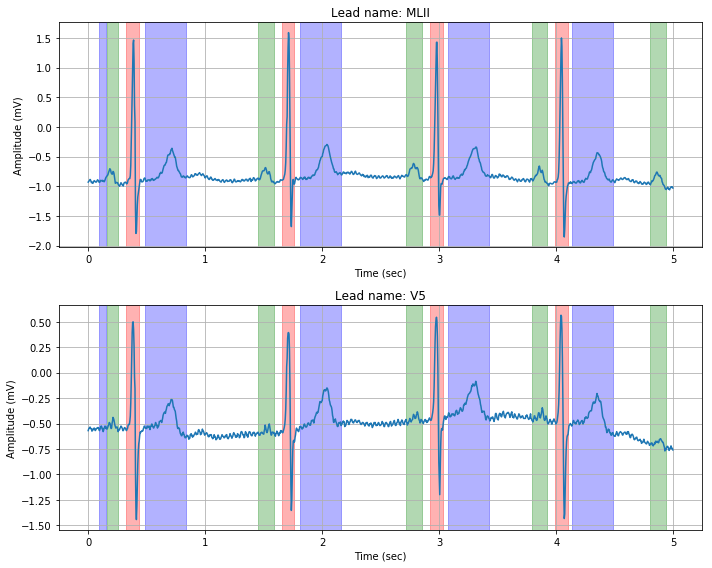

Heart rate: 50 bpm


In [20]:
batch.show_ecg(batch.indices[example_1], 5, 10, "hmm_annotation")
print("Heart rate: %d bpm" %batch.meta[example_1]["hr"])

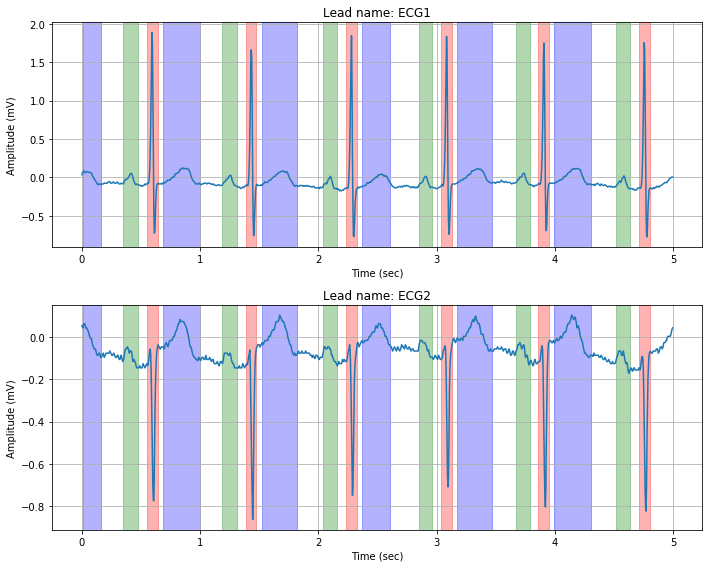

Heart rate: 71 bpm


In [21]:
batch.show_ecg(batch.indices[example_2], 0, 5, "hmm_annotation")
print("Heart rate: %d bpm" %batch.meta[example_2]["hr"])